In [19]:
# implementation partly follows https://www.kaggle.com/kredy10/simple-lstm-for-text-classification/data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
%matplotlib inline

In [20]:
# load positive labels
pos = open('data/ira_10000.csv').read()
npos = 0
labels, texts = [], []
for i, line in enumerate(pos.split("\n")):
    content = line.split(',')
    if len(content) < 4:
    	continue;
    if content[4] != "English":
    	continue;
    labels.append(1)
    texts.append(content[2])
    npos += 1

# load negative labels (random tweets)
neg = open('data/tweets-2016-10000-textonly.txt').read()
nneg = 0
for i, line in enumerate(neg.split("\n")):
    labels.append(0)
    texts.append(line)
    nneg += 1

texts, labels = shuffle(texts, labels)

print('Total number of datapoints: ', len(labels))
print('Positive labels: ', npos)
print('Negative labels: ', nneg)

df = pd.DataFrame()
df['text'] = texts
df['label'] = labels

df.head()

Total number of datapoints:  12514
Positive labels:  4541
Negative labels:  7973


,text,label
0,I liked a @YouTube video https://t.co/NzBhCe0A...,0
1,CNN won't show it's viewers these amazing patr...,1
2,oh China... https://t.co/SX7DuSo7Sz,1
3,Virginia cops try to bully family farm over #B...,1
4,https://t.co/ABJx7SzsKU #linmanuelmiranda xxxx...,0


Text(0.5, 1.0, 'Breakdown by label type')

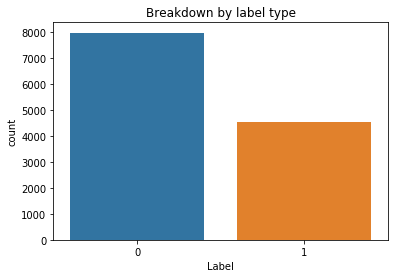

In [21]:
sns.countplot(df.label)
plt.xlabel('Label')
plt.title('Breakdown by label type')

In [22]:
enc = LabelEncoder()
y = enc.fit_transform(labels).reshape(-1,1)
train_x, test_x, train_y, test_y = train_test_split(df['text'], y, test_size=0.20)

# Tokenize the text. Max length 280 (may tweak)


maxlen = 280
maxwords = 10000

token = Tokenizer(num_words=maxwords)
token.fit_on_texts(df['text'])

sequences = token.texts_to_sequences(train_x)
padded = sequence.pad_sequences(sequences, maxlen=maxlen)


In [23]:
def make_rnn():
    inputs = Input(name='inputs',shape=[maxlen])
    layer = Embedding(maxwords,50,input_length=maxlen)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = make_rnn()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 280)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 280, 50)           500000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

In [ ]:
history = model.fit(padded,train_y,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[])

Train on 8008 samples, validate on 2003 samples
Epoch 1/10
8008/8008 [==============================] - 24s 3ms/step - loss: 0.6431 - acc: 0.7958 - val_loss: 0.2415 - val_acc: 0.8837
Epoch 2/10
8008/8008 [==============================] - 22s 3ms/step - loss: 0.1416 - acc: 0.9456 - val_loss: 0.1239 - val_acc: 0.9506
Epoch 3/10
8008/8008 [==============================] - 23s 3ms/step - loss: 0.0871 - acc: 0.9719 - val_loss: 0.1059 - val_acc: 0.9591
Epoch 4/10
8008/8008 [==============================] - 27s 3ms/step - loss: 0.0652 - acc: 0.9779 - val_loss: 0.1139 - val_acc: 0.9636
Epoch 5/10
1024/8008 [==>...........................] - ETA: 25s - loss: 0.0426 - acc: 0.9834

In [15]:
test_sequences = token.texts_to_sequences(test_x)
test_padded = sequence.pad_sequences(test_sequences,maxlen=maxlen)

accuracy = model.evaluate(test_padded, test_y)
print('Test loss: ', accuracy[0])
print('Test accuracy: ', accuracy[1])



2503/2503 [==============================] - 3s 1ms/step
Test loss:  0.15382436748342518
Test accuracy:  0.9332800639471053


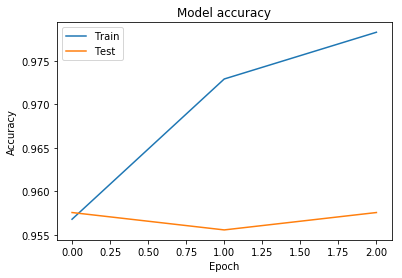

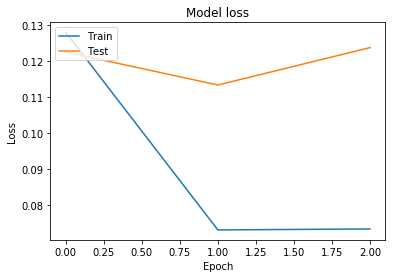

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()